In [51]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  2.0.0
pandas version :  2.2.2
seaborn version :  0.13.2


# **Import Dataset**

In [52]:
df = pd.read_csv('df_analysis.csv')

df.sample(10)


,Agency,Type,Distribution,Product,Duration,Destination,Sales,Commision,Age,Claim
2852,JZI,Airlines,Online,Basic Plan,34,HONG KONG,22.00,7.70,41,No
4876,JZI,Airlines,Online,Basic Plan,5,THAILAND,22.00,7.70,50,No
5700,C2B,Airlines,Online,Silver Plan,5,SINGAPORE,24.05,6.01,57,No
2079,C2B,Airlines,Online,Bronze Plan,24,SINGAPORE,18.00,4.50,29,No
2472,C2B,Airlines,Online,Silver Plan,8,SINGAPORE,29.00,7.25,33,No
6120,JZI,Airlines,Online,Basic Plan,40,HONG KONG,35.00,12.25,68,No
4748,JZI,Airlines,Online,Basic Plan,3,INDIA,22.00,7.70,26,No
2261,CCR,Travel Agency,Offline,Comprehensive Plan,42,MALAYSIA,29.00,9.57,67,No
4910,JZI,Airlines,Online,Basic Plan,10,HONG KONG,26.00,9.10,69,No
1202,C2B,Airlines,Online,Bronze Plan,5,SINGAPORE,17.55,4.39,32,Yes


## **Modelling**

### **Function**

In [53]:
def target_encode(df, categorical_column, target_column):
    # Calculate mean of target variable for each category
    mean_encoded = df.groupby(categorical_column)[target_column].mean()
    df[categorical_column + '_encoded'] = df[categorical_column].map(mean_encoded)
    return df

In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(model):
    y_pred = model.predict_proba(x_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0,1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0,1], [0,1], 'k--' )
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_threshold_point(model, threshold_value):
    y_pred = model.predict_proba(x_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0,1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    # Menandai threshold value
    idx = np.argmin(np.abs(threshold - threshold_value))
    plt.scatter(fpr[idx], tpr[idx], c='red', s=70, label=f'Threshold {threshold_value}')
    
    # garis putus-putus dari titik threshold ke sumbu TPR dan FPR
    plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', linewidth=1)
    plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', linewidth=1)
    

    plt.plot([0,1], [0,1], 'k--' )
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

In [56]:
def plot_feature_importances(model):
    import pandas as pd
    import matplotlib.pyplot as plt

    # feature importances
    feature_importances = pd.DataFrame({
        'feature': x_train.columns,
        'importance': model.feature_importances_
    })

    
    feature_importances = feature_importances.reset_index(drop=True)

    # Group by
    fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)[:20][::-1]

    # Plot
    plt.figure(figsize=(6, 5))
    fi.plot(kind='barh')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Top Feature Importances - {model}')
    plt.show()

# Contoh pemanggilan
# plot_feature_importances(best_model_xgb)


In [57]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

def eval_classification(model):
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    y_pred_proba = model.predict_proba(x_test)
    y_pred_proba_train = model.predict_proba(x_train)
    
    # Evaluation Metrics
    print(f'model {model}')
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("ROC AUC (Test Set): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("ROC AUC (Train Set): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

   
    # Cross-validation
    score = cross_validate(model, x_train, y_train, cv=5, scoring='recall', return_train_score=True)
    print('\nRecall (Cross-validation Train): %.2f' % score['train_score'].mean())
    print('Recall (Cross-validation Test): %.2f' % score['test_score'].mean())
    
    # Confusion Matrix
    print("\nConfusion Matrix (Test Set):\n", confusion_matrix(y_test, y_pred))

def show_best_hyperparameter(model):
    if hasattr(model, 'best_estimator_'):
        print(model.best_estimator_.get_params())
    else:
        print("The model is not a GridSearchCV or RandomizedSearchCV instance.")

# Example usage
# Assuming x_train, x_test, y_train, y_test are already defined
#model = RandomForestClassifier(random_state=42)
#model.fit(x_train, y_train.values.ravel())

#eval_classification(model)
#show_feature_importance(model)

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model):
    
    y_pred = model.predict(x_test)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def draw_learning_curve(model_type, param_values):
    if model_type == 'LogisticRegression':
        model = LogisticRegression()
    elif model_type == 'KNeighborsClassifier':
        model = KNeighborsClassifier()
    elif model_type == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier()
    elif model_type == 'RandomForestClassifier':
        model = RandomForestClassifier()
    elif model_type == 'SVC':
        model = SVC(probability=True)
    else:
        raise ValueError("Invalid model type. Supported types are 'LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier', and 'SVC'.")

    train_scores = []
    test_scores = []

    for param_value in param_values:
        if model_type == 'LogisticRegression':
            model.set_params(C=param_value)
        elif model_type == 'KNeighborsClassifier':
            model.set_params(n_neighbors=param_value)
        elif model_type == 'DecisionTreeClassifier':
            model.set_params(max_depth=param_value)
        elif model_type == 'RandomForestClassifier':
            model.set_params(n_estimators=param_value)
        elif model_type == 'SVC':
            model.set_params(C=param_value)

        model.fit(x_train, y_train)

        # eval train
        y_pred_train_proba = model.predict_proba(x_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval test
        y_pred_proba = model.predict_proba(x_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(param_value) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('Parameter Value')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter Tuning - ' + model_type)
    plt.legend()
    plt.show()

#contoh pemanggilan
#param_values_rf = [50, 100, 150, 200]
#draw_learning_curve('RandomForestClassifier', param_values_rf)

#param_values_svc = [0.1, 1, 10]
#draw_learning_curve('SVC', param_values_svc)


In [60]:
def optimal_threshold(model):
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Filter thresholds kriteria TPR > 0.5 dan FPR > 0.05 serta < 0.15
    candidate_thresholds = thresholds[(tpr > 0.5) & (fpr > 0.05) & (fpr < 0.15)]

    optimal_threshold = candidate_thresholds[np.argmax(tpr[fpr > 0.05] - fpr[fpr > 0.05])]

    # Prediksi label menggunakan threshold yang dioptimalkan
    y_pred_optimal = (y_pred >= optimal_threshold).astype(int)

    # Precision, Recall, F1-score
    precision = precision_score(y_test, y_pred_optimal)
    recall = recall_score(y_test, y_pred_optimal)
    f1 = f1_score(y_test, y_pred_optimal)

    # True Positive Rate (TPR) & False Positive Rate (FPR)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    print(f'\nOptimal threshold {model}: {optimal_threshold:.2f}')
    print(f'\nPrecision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')
    print(f'TPR: {tpr:.2f}')
    print(f'FPR: {fpr:.2f}')

In [61]:
def optimal_threshold_recall(model):
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Filter thresholds kriteria TPR > 0.5 dan FPR > 0.05 serta < 0.15
    candidate_thresholds = thresholds[(tpr > 0.8) & (fpr > 0.1) & (fpr < 0.5)]

    optimal_threshold = candidate_thresholds[np.argmax(tpr[fpr > 0.1] - fpr[fpr > 0.1])]

    # Prediksi label menggunakan threshold yang dioptimalkan
    y_pred_optimal = (y_pred >= optimal_threshold).astype(int)

    # Precision, Recall, F1-score
    precision = precision_score(y_test, y_pred_optimal)
    recall = recall_score(y_test, y_pred_optimal)
    f1 = f1_score(y_test, y_pred_optimal)

    # True Positive Rate (TPR) & False Positive Rate (FPR)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    print(f'\nOptimal threshold {model}: {optimal_threshold:.2f}')
    print(f'\nPrecision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')
    print(f'TPR: {tpr:.2f}')
    print(f'FPR: {fpr:.2f}')

In [62]:
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

def set_roc_threshold(model, threshold):

    # Probability of model 
    y_probs = model.predict_proba(x_test)[:, 1]
    
    # Set threshold
    y_pred_new_threshold = (y_probs >= threshold).astype(int)

    # Model Eval
    conf_matrix = confusion_matrix(y_test, y_pred_new_threshold)

    # Plot the confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, roc_curve, confusion_matrix

def table_threshold(model):

    y_probs = model.predict_proba(x_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)


    # Range nilai threshold
    desired_thresholds = np.arange(0.0, 1.1, 0.1)

    results = []

    # precision, recall, dan f-score 
    for threshold in desired_thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        results.append({
            'Threshold': threshold,
            'Precision': precision,
            'Recall': recall,
            'F-Score': fscore,
            'TPR': tpr,
            'FPR': fpr
        })

    df_results = pd.DataFrame(results)
    return df_results

# **Encoding**

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8764 entries, 0 to 8763
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Agency        8764 non-null   object 
 1   Type          8764 non-null   object 
 2   Distribution  8764 non-null   object 
 3   Product       8764 non-null   object 
 4   Duration      8764 non-null   int64  
 5   Destination   8764 non-null   object 
 6   Sales         8764 non-null   float64
 7   Commision     8764 non-null   float64
 8   Age           8764 non-null   int64  
 9   Claim         8764 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 684.8+ KB


In [65]:
# Convert 'Claim' column to binary values: 1 for 'Yes', 0 for 'No'
df['Claim'] = df['Claim'].map({'Yes': 1, 'No': 0})

In [66]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding for 'Type' and 'Distribution'
df = pd.get_dummies(df, columns=['Type', 'Distribution'], drop_first=True)

df['Type_Travel Agency'] = df['Type_Travel Agency'].astype(int)
df['Distribution_Online'] = df['Distribution_Online'].astype(int)

In [67]:
# Apply target encoding for each column
target_columns = ['Agency', 'Product', 'Destination']
for column in target_columns:
    df = target_encode(df, column, 'Claim')

In [75]:
frequency = df['Destination_encoded'].value_counts().reset_index()
frequency.columns = ['Destination_encoded', 'Frequency']
destination_mapping = df[['Destination_encoded', 'Destination']].drop_duplicates().sort_values(by='Destination_encoded', ascending=False)
combined_df = destination_mapping.merge(frequency, on='Destination_encoded', how='left')

print(combined_df.sort_values(by='Frequency', ascending=False))


    Destination_encoded                       Destination  Frequency
1              0.059218                         SINGAPORE       3732
10             0.004296                          THAILAND        931
12             0.000000                             INDIA        866
22             0.000000                        BANGLADESH        866
21             0.000000              UNITED ARAB EMIRATES        866
20             0.000000                          CAMBODIA        866
19             0.000000         TAIWAN, PROVINCE OF CHINA        866
18             0.000000  LAO PEOPLE'S DEMOCRATIC REPUBLIC        866
17             0.000000                             MACAO        866
16             0.000000                         SRI LANKA        866
15             0.000000                           MYANMAR        866
14             0.000000         IRAN, ISLAMIC REPUBLIC OF        866
13             0.000000                       PHILIPPINES        866
29             0.000000           

In [18]:
df.drop(columns=['Agency', 'Product', 'Destination'], inplace=True)

In [50]:
# Hitung frekuensi nilai dari kolom Destination_encoded
frequency = df['Destination_encoded'].value_counts()

# Cetak frekuensi dari nilai tertinggi ke terkecil
print(frequency)


Destination_encoded
0.059218    3732
0.004296     931
0.000000     866
0.006711     745
0.006163     649
0.011538     520
0.004773     419
0.003165     316
0.016043     187
0.034722     144
0.007634     131
0.008850     113
0.090909      11
Name: count, dtype: int64


In [19]:
df.sample(5)

,Duration,Sales,Commision,Age,Claim,Type_Travel Agency,Distribution_Online,Agency_encoded,Product_encoded,Destination_encoded
520,35,61.50,15.38,22,0,0,1,0.059457,0.057260,0.059218
2647,19,33.50,8.38,32,0,0,1,0.059457,0.032520,0.059218
6424,109,40.00,14.00,27,0,0,1,0.004756,0.004319,0.034722
728,5,21.00,5.25,41,0,0,1,0.059457,0.057260,0.059218
7800,4,17.55,4.39,32,0,0,1,0.059457,0.057260,0.059218


In [20]:
df.to_csv('df_encoded.csv', index=False)

<Axes: >

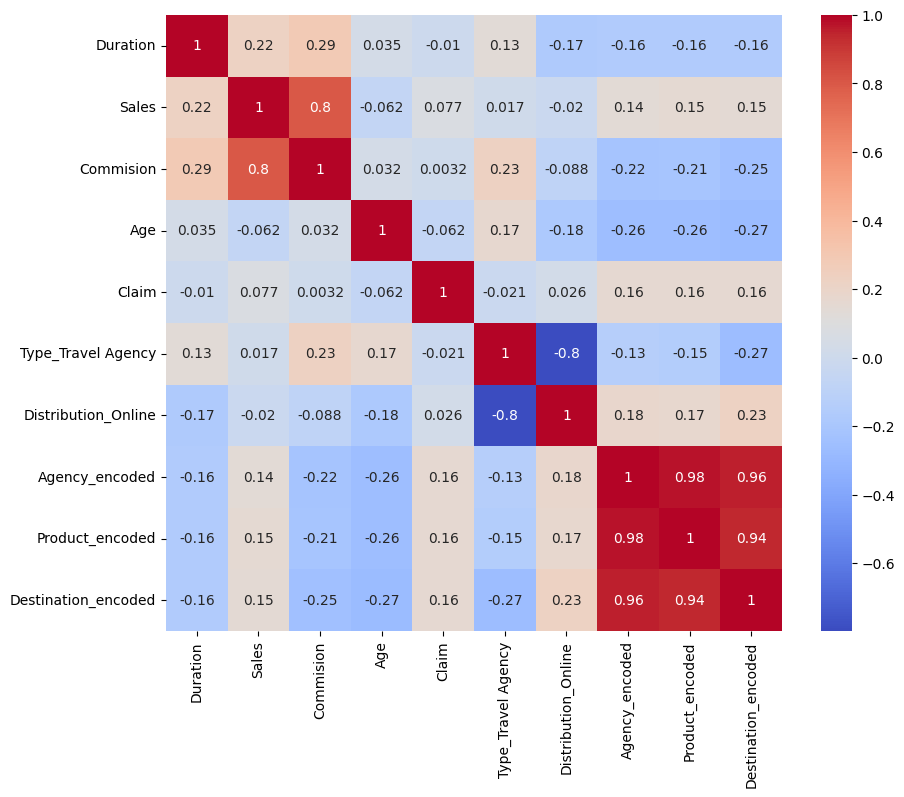

In [21]:
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), square=True,annot=True,cmap= 'coolwarm')

# **SMOTE**

- Because data is imbalance

In [22]:
X = df.drop(columns=['Claim'])
y = df[['Claim']]


In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)
print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')
print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (8764, 9)
Shape of X after SMOTE: (17020, 9)

Balance of positive and negative classes (%):


Claim
0        50.0
1        50.0
Name: proportion, dtype: float64

In [24]:
X_sm

,Duration,Sales,Commision,Age,Type_Travel Agency,Distribution_Online,Agency_encoded,Product_encoded,Destination_encoded
0,19,22.000000,7.700000,26,0,1,0.004756,0.004319,0.000000
1,8,16.000000,4.000000,28,0,1,0.059457,0.057260,0.059218
2,4,22.000000,7.700000,39,0,1,0.004756,0.004319,0.004296
3,103,26.000000,9.100000,48,0,1,0.004756,0.004319,0.034722
4,12,30.000000,10.500000,35,0,1,0.004756,0.004319,0.016043
...,...,...,...,...,...,...,...,...,...
17015,3,24.875176,6.219749,39,0,1,0.059457,0.057260,0.059218
17016,9,17.821200,4.458037,28,0,1,0.059457,0.062600,0.059218
17017,15,44.532769,11.133192,24,0,1,0.059457,0.062073,0.059218
17018,12,22.983672,5.746081,27,0,1,0.059457,0.057578,0.059218


In [25]:
y

,Claim
0,0
1,0
2,0
3,0
4,1
...,...
8759,0
8760,0
8761,0
8762,0


# **Scaling**

In [26]:
#Min-max scaling

X_new=pd.DataFrame()
to_scale = X_sm.columns
mms = MinMaxScaler()
X_new[to_scale] = mms.fit_transform(X_sm[to_scale])
X_new.head()

,Duration,Sales,Commision,Age,Type_Travel Agency,Distribution_Online,Agency_encoded,Product_encoded,Destination_encoded
0,0.143939,0.324484,0.350637,0.305882,0.0,1.0,0.079985,0.064449,0.000000
1,0.060606,0.235988,0.169442,0.329412,0.0,1.0,1.000000,0.854434,0.651393
2,0.030303,0.324484,0.350637,0.458824,0.0,1.0,0.079985,0.064449,0.047261
3,0.780303,0.383481,0.419197,0.564706,0.0,1.0,0.079985,0.064449,0.381944
4,0.090909,0.442478,0.487757,0.411765,0.0,1.0,0.079985,0.064449,0.176471


In [27]:
df_smote = pd.concat([X_new, y_sm], axis=1)


In [28]:
df_smote.to_csv('df_smote.csv', index=False)

# **Split Dataset**

In [29]:
#Split data
x_train, x_test, y_train, y_test = train_test_split(X_new, y_sm, test_size=0.25, random_state=42)

# **ML Algorithm**

## Decision Tree

model DecisionTreeClassifier()
Accuracy (Test Set): 0.95
Precision (Test Set): 0.94
Recall (Test Set): 0.96
F1-Score (Test Set): 0.95
ROC AUC (Test Set): 0.95
ROC AUC (Train Set): 1.00

Recall (Cross-validation Train): 1.00
Recall (Cross-validation Test): 0.95

Confusion Matrix (Test Set):
 [[2038  131]
 [  93 1993]]


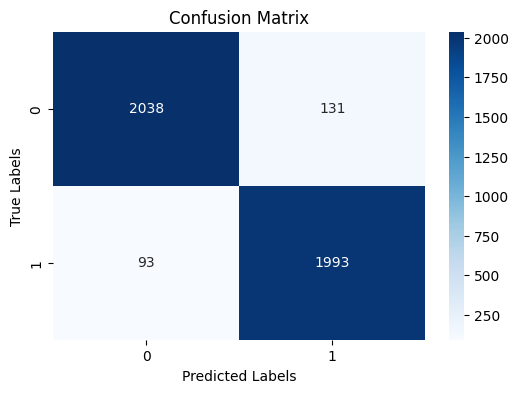

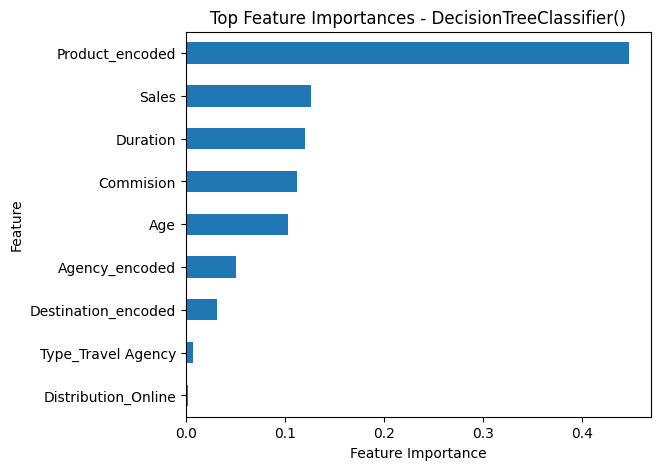

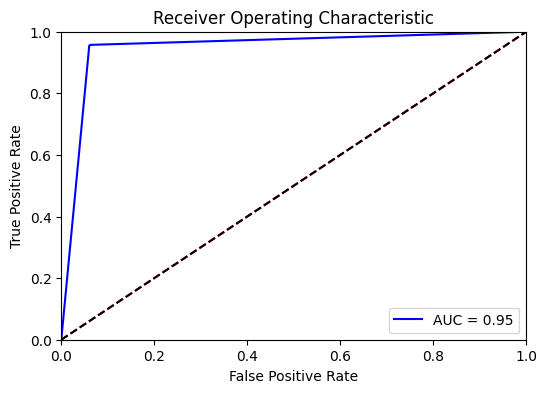

In [30]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
eval_classification(dt)
plot_confusion_matrix(dt)
plot_feature_importances(dt)
plot_roc(dt)

In [31]:
optimal_threshold(dt)


Optimal threshold DecisionTreeClassifier(): 0.60

Precision: 0.94
Recall: 0.95
F1-score: 0.95
TPR: 0.95
FPR: 0.06


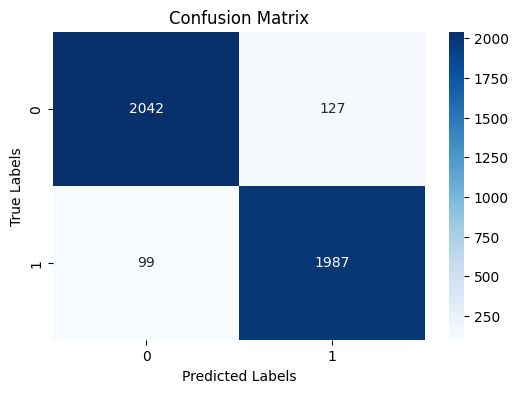

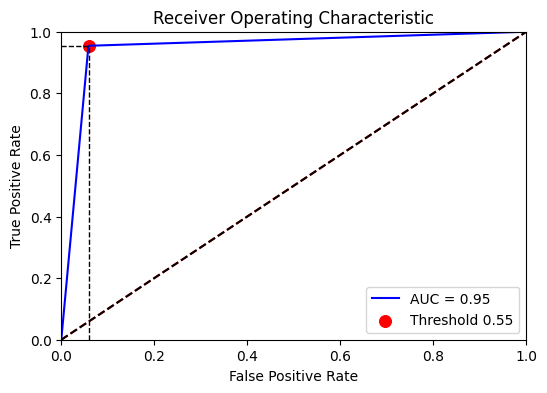

In [32]:
set_roc_threshold(dt, 0.55)
plot_roc_threshold_point(dt, 0.55)

## Random Forest

model RandomForestClassifier()
Accuracy (Test Set): 0.97
Precision (Test Set): 0.96
Recall (Test Set): 0.97
F1-Score (Test Set): 0.97
ROC AUC (Test Set): 0.99
ROC AUC (Train Set): 1.00

Recall (Cross-validation Train): 1.00
Recall (Cross-validation Test): 0.97

Confusion Matrix (Test Set):
 [[2094   75]
 [  67 2019]]


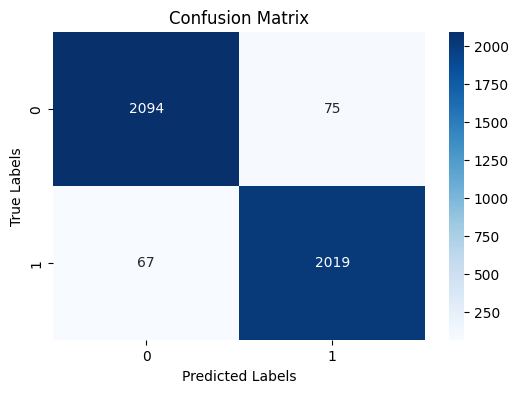

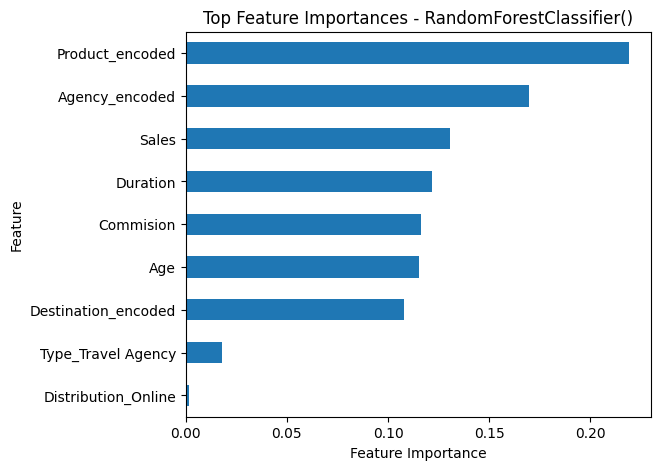

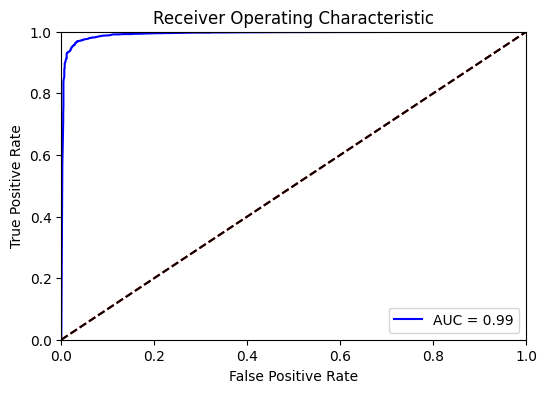

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
eval_classification(rf)
plot_confusion_matrix(rf)
plot_feature_importances(rf)
plot_roc(rf)

In [34]:
optimal_threshold(rf)


Optimal threshold RandomForestClassifier(): 0.41

Precision: 0.95
Recall: 0.98
F1-score: 0.96
TPR: 0.98
FPR: 0.05


In [35]:
table_threshold(rf)

,Threshold,Precision,Recall,F-Score,TPR,FPR
0,0.0,0.490247,1.000000,0.657940,1.000000,1.000000
1,0.1,0.828606,0.994247,0.903901,0.994247,0.197787
2,0.2,0.879303,0.991850,0.932192,0.991850,0.130936
3,0.3,0.918714,0.986098,0.951214,0.986098,0.083910
4,0.4,0.944958,0.979386,0.961864,0.979386,0.054864
5,0.5,0.963740,0.968360,0.966045,0.968360,0.035039
6,0.6,0.975049,0.955417,0.965133,0.955417,0.023513
7,0.7,0.984833,0.933845,0.958661,0.933845,0.013831
8,0.8,0.991076,0.905081,0.946129,0.905081,0.007838
9,0.9,0.993270,0.848993,0.915482,0.848993,0.005533


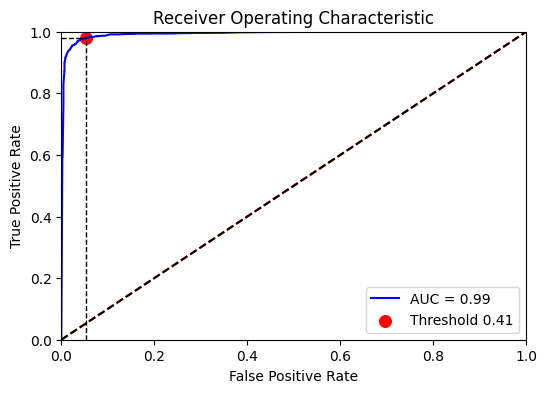

In [36]:
plot_roc_threshold_point(rf, 0.41)

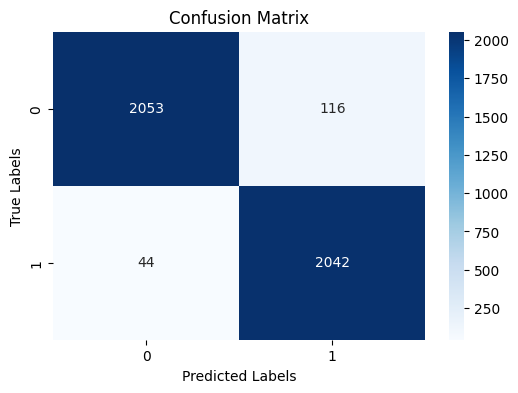

In [37]:
set_roc_threshold(rf, 0.41)

In [38]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_test)


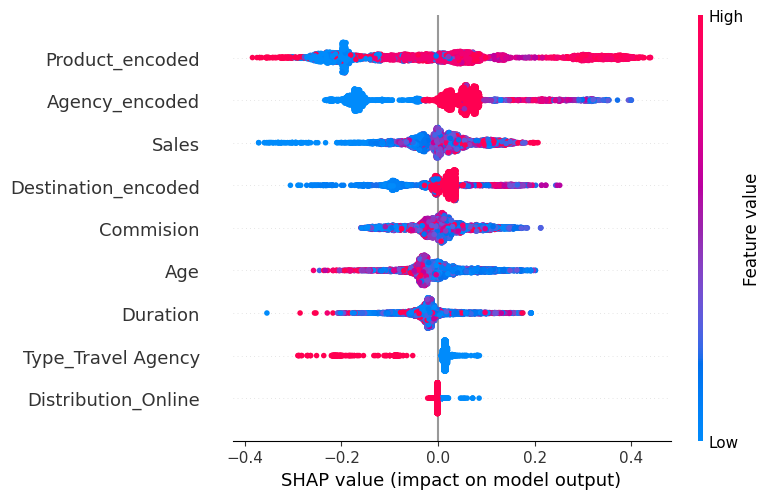

In [39]:
shap.summary_plot(shap_values[:, :, 1], x_test)


## Gradient Boosting Classifier

model GradientBoostingClassifier()
Accuracy (Test Set): 0.86
Precision (Test Set): 0.80
Recall (Test Set): 0.95
F1-Score (Test Set): 0.87
ROC AUC (Test Set): 0.96
ROC AUC (Train Set): 0.96

Recall (Cross-validation Train): 0.95
Recall (Cross-validation Test): 0.95

Confusion Matrix (Test Set):
 [[1664  505]
 [ 108 1978]]


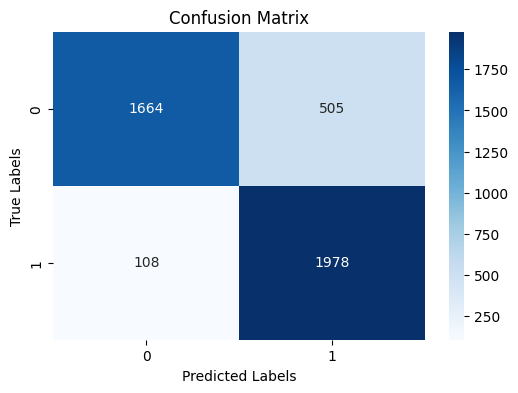

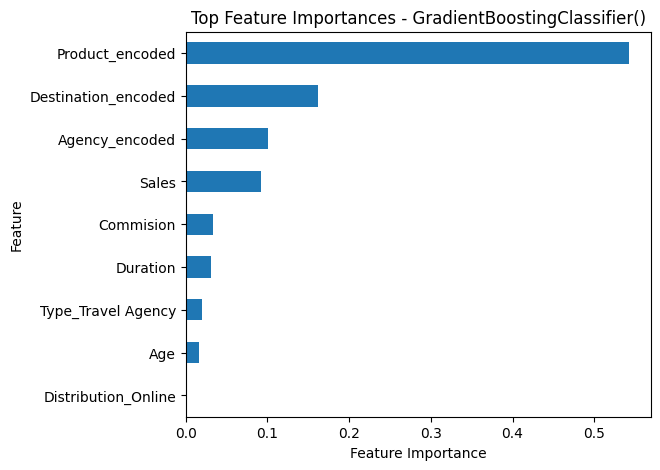

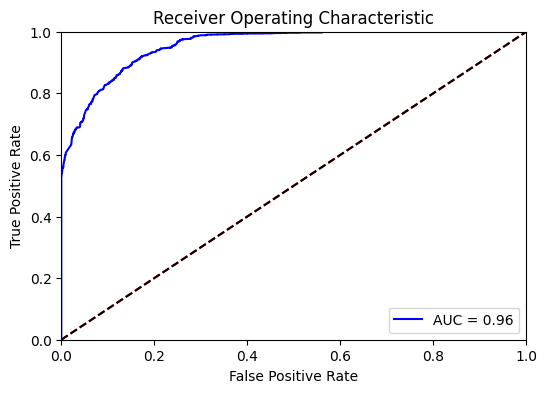

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
eval_classification(gbc)
plot_confusion_matrix(gbc)
plot_feature_importances(gbc)
plot_roc(gbc)

In [41]:
optimal_threshold(gbc)


Optimal threshold GradientBoostingClassifier(): 0.58

Precision: 0.86
Recall: 0.88
F1-score: 0.87
TPR: 0.88
FPR: 0.13


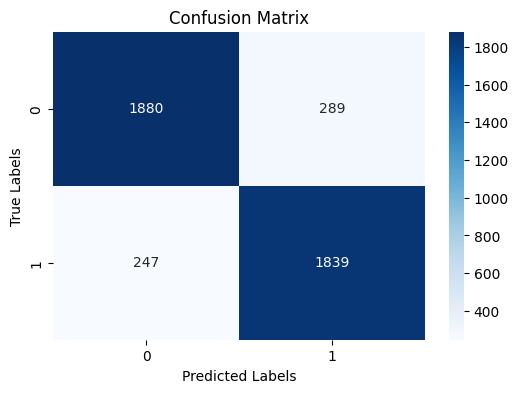

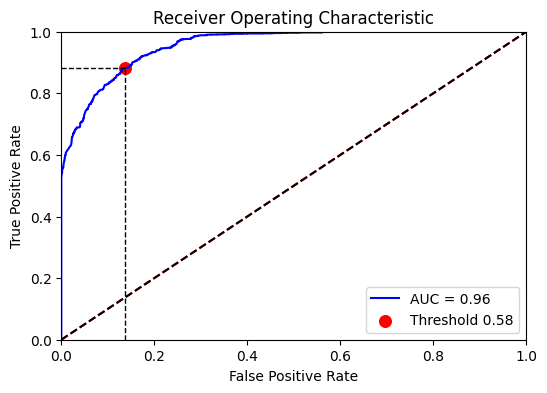

In [42]:
set_roc_threshold(gbc, 0.58)
plot_roc_threshold_point(gbc, 0.58)

## XGboost

model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy (Test Set): 0.95
Precision (Test Set): 0.94
Recall (Test Set): 0.97
F1-Score (Test Set): 0.95
ROC AUC (Test Set): 0.99
ROC AUC (Train Set): 1.00

Recall (Cross-validation Train): 0.98
Recall (Cross-validation Test): 0.96

Confu

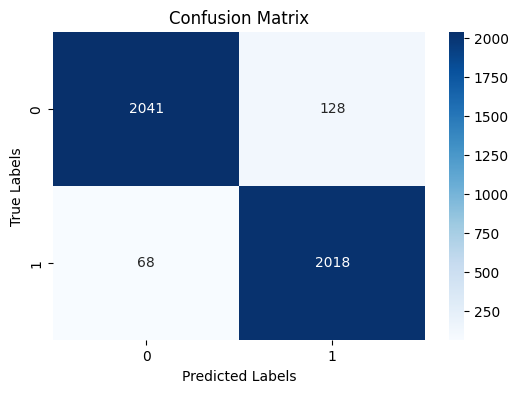

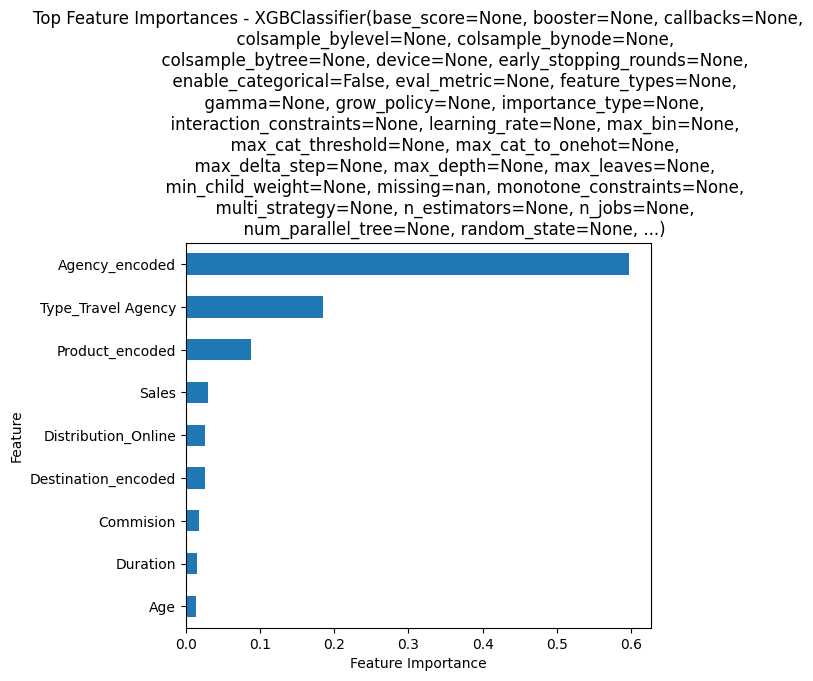

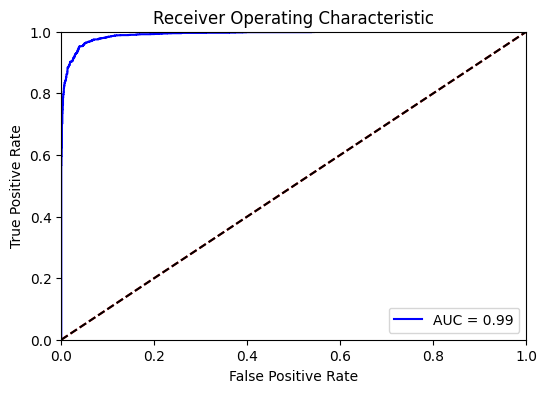

In [43]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, y_train)
eval_classification(xgb)
plot_confusion_matrix(xgb)
plot_feature_importances(xgb)
plot_roc(xgb)

In [44]:
optimal_threshold(xgb)


Optimal threshold XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...): 0.54

Precision: 0.95
Recall: 0.96
F1-score: 0.96
TPR: 0.96
FPR: 0.05


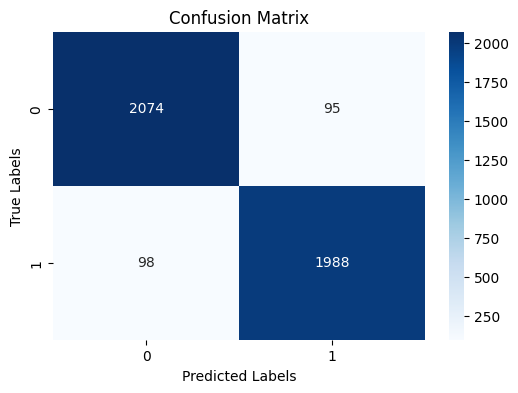

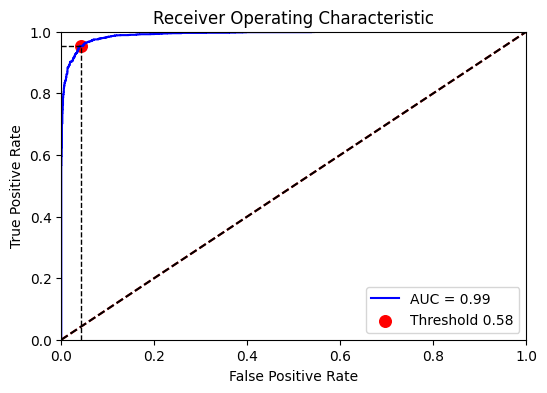

In [45]:
set_roc_threshold(xgb, 0.58)
plot_roc_threshold_point(xgb, 0.58)

# Best Algorithm

In [46]:
eval_classification(rf)
eval_classification(dt)
eval_classification(gbc)
eval_classification(xgb)

model RandomForestClassifier()
Accuracy (Test Set): 0.97
Precision (Test Set): 0.96
Recall (Test Set): 0.97
F1-Score (Test Set): 0.97
ROC AUC (Test Set): 0.99
ROC AUC (Train Set): 1.00

Recall (Cross-validation Train): 1.00
Recall (Cross-validation Test): 0.97

Confusion Matrix (Test Set):
 [[2093   76]
 [  69 2017]]
model DecisionTreeClassifier()
Accuracy (Test Set): 0.95
Precision (Test Set): 0.94
Recall (Test Set): 0.95
F1-Score (Test Set): 0.95
ROC AUC (Test Set): 0.95
ROC AUC (Train Set): 1.00

Recall (Cross-validation Train): 1.00
Recall (Cross-validation Test): 0.95

Confusion Matrix (Test Set):
 [[2042  127]
 [  99 1987]]
model GradientBoostingClassifier()
Accuracy (Test Set): 0.86
Precision (Test Set): 0.80
Recall (Test Set): 0.95
F1-Score (Test Set): 0.87
ROC AUC (Test Set): 0.96
ROC AUC (Train Set): 0.96

Recall (Cross-validation Train): 0.95
Recall (Cross-validation Test): 0.95

Confusion Matrix (Test Set):
 [[1664  505]
 [ 108 1978]]
model XGBClassifier(base_score=None, bo